<a href="https://colab.research.google.com/github/KalharaBatangala/FashionMNIST/blob/main/FashionImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms

from PIL import Image   # just import only class Image
import matplotlib.pyplot as plt


Flattening destroys locality
<br>Convolutions preserve it

In [2]:
# Convert PIL images to pytorch tensors
transforms = transforms.ToTensor()

In [3]:
# load train dataset
train_data = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms
)

# no of training exmples
print(f'Number of training examples {len(train_data)}')

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 305kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.62MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.1MB/s]

Number of training examples 60000


torch.Size([1, 28, 28])
torch.Size([28, 28])


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

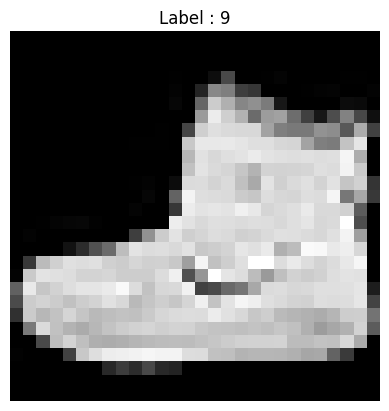

In [4]:
image, label = train_data[0]  # take one training exmple

print(image.shape)  # [1,28,28] (C, H, W) because it is a pytorch tensor
img_2d = image.squeeze()  # remove channel dimension
print(img_2d.shape) # now (H, W)
plt.imshow(img_2d, cmap='gray')  # it work with matplotlib
plt.title(f"Label : {label}")
plt.axis("off")
# matplotlib expects ---> (H, W) for grayscale and (H, W, C) for color
# pytorch returns ---> (C, H, W) but this is different in tensorflow. Channel last

in pytorch, channel is the first value <br>
torch.Size([1,28,28]) only 1 channel

In [5]:
# load test dataset
test_data = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms
)


In [6]:
print(f'Number of test examples {len(test_data)}')

Number of test examples 10000


In [7]:
from torch.utils.data import DataLoader

In [8]:
batch_size = 64

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)



In [9]:
# Inspect one batch
images, labels = next(iter(train_loader))

print("Batch image shape:", images.shape)
print("Batch labels shape:", labels.shape)


Batch image shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])


In [10]:
import torch.nn as nn

**Convolutional block - 1**

In [11]:
conv_layer = nn.Conv2d(
    in_channels=1,
    out_channels=32,
    kernel_size=3,
    stride=1,
    padding=1   # keep spatial size
)

relu = nn.ReLU()
pool = nn.MaxPool2d(
    kernel_size=2,    # half the size
    stride=2
)


This is a feature extractor. Next we want a classifier, <br>
that means a fully connected layer

In [33]:
# Pass one batch through the block
images, labels = next(iter(train_loader))

x = conv_layer(images)
x = relu(x)
x = pool(x)

print("After Conv:", conv_layer(images).shape)
print("After ReLU:", relu(conv_layer(images)).shape)
print("After Pool:", x.shape)

After Conv: torch.Size([64, 32, 28, 28])
After ReLU: torch.Size([64, 32, 28, 28])
After Pool: torch.Size([64, 32, 14, 14])


torch.Size([64, 32, 28, 28]) <br>
this always follows the pytorch's convention (N, C, H, W)
<br>
64 = batch size (N) meaning 64 different stacks of
<br> 32 feature maps

CNNs do NOT detect objects <br> <br>
They detect **features**

**Classifier**

In [34]:
fc = nn.Linear(32 * 14 * 14, 10)  # 10 classes in fashionMNIST

# Forward pass continued
x = x.view(x.size(0), -1)  # Flatten

print("After flatten:", x.shape)

x = fc(x)

print("After Linear:", x.shape)   # gives 10 output logits

After flatten: torch.Size([64, 6272])
After Linear: torch.Size([64, 10])


Logits = raw, unnormalized scores produced by the model

In [20]:
# torch.Size([64, 6272])

# column vector of 6272

**LOSS + BACKPROPAGATION**

In [35]:
# define loss function
criterion = nn.CrossEntropyLoss()   # expects logits

# Compute Loss
loss = criterion(x, labels)

print("Loss value: ", loss.item())

# backward pass
loss.backward()     # compute gradients but do not update weights

print("Backward pass completed")

Loss value:  2.2900590896606445
Backward pass completed


average loss per image in the batch: **2.3259010314941406**

In [36]:
print(fc.weight.grad.shape)


torch.Size([10, 6272])


**Optimizer**

In [38]:
import torch.optim as optim

# define optimizer
optimizer = optim.SGD(
    fc.parameters(),
    lr=0.01
)


# clear gradients
optimizer.zero_grad()

# update
optimizer.step()

print("Weights updated for one step")

Weights updated for one step


**why SGD?**  <br>
simple and predictable <br>
θ = θ - lr * gradient


| Term                  | Meaning                                                                                           | Typical Usage                            |
| --------------------- | ------------------------------------------------------------------------------------------------- | ---------------------------------------- |
| **Transfer Learning** | Take a **pretrained model** on large dataset (like ImageNet) and use it for your task             | Freeze conv layers → train only new head |
| **Fine-Tuning**       | Take **pretrained model**, optionally unfreeze some or all layers, and train them on your dataset | Gradually update conv layers + new head  |


In [43]:
import torch.nn as nn
import torch.nn.functional as F

In [45]:
class CNN(nn.Module):
  def __init__(self, in_channels=1, num_classes=10):
    super(CNN, self).__init__()

    # conv layer 1
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # conv layer 2
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

    # fc layer
    self.fc = nn.Linear(64 * 7 * 7, num_classes)  # 64 is the out channels after 2nd convo layer, not batch size
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)

    # passing through 2nd convo block
    x = F.relu(self.conv2(x))
    x = self.pool(x)

    x = x.view(x.size(0), -1) # flatten before fc layer
    x = self.fc(x)

    return x

#


In [47]:
# Instantiate the model
model = CNN()

# define loss
criterion  = nn.CrossEntropyLoss()

# optimizer/ adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

# clear before update
optimizer.zero_grad()


In [48]:
# Get one batch of data
images, labels = next(iter(train_loader))

# forward pass
outputs = model(images)

# compute loss
loss = criterion(outputs, labels)

print("Loss: ", loss.item())  # since criterion defined with reduction = 'mean'

# compute gradients
loss.backward()


Loss:  2.3157966136932373


In [49]:
# update
optimizer.step()

print("Weights updated")

Weights updated


**Training Loop**

In [51]:
epochs = 5
learning_rate = 0.001

for epoch in range(epochs):
  running_loss = 0.0

  for batch_idx, (images, labels) in enumerate(train_loader):
    # clear grads
    optimizer.zero_grad()

    # forward
    outputs = model(images)

    # compute loss
    loss = criterion(outputs, labels)

    # backprop
    loss.backward()

    # update
    optimizer.step()

    # accumulate loss for reporting
    running_loss += loss.item()

  # print avg loss for epoch
  print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training completed")

Epoch [1/5], Loss: 0.3113
Epoch [2/5], Loss: 0.2705
Epoch [3/5], Loss: 0.2427
Epoch [4/5], Loss: 0.2238
Epoch [5/5], Loss: 0.2071
Training completed


In [52]:
# Compute training accuracy per epoch
correct = 0
total = 0
with torch.no_grad():
    for images, labels in train_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Training Accuracy: {100*correct/total:.2f}%")


Training Accuracy: 93.20%
